## Burgers' Equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

### Data

In [3]:
## Data
import scipy

data = scipy.io.loadmat("data/burgers_data_R10.mat")
x_data_all = data["a"]   # a(x): initial condition       (2048, 8192)
y_data_all = data["u"]   # u(x): PDE solution at t = 1   (2048, 8192)

sub_sampling = 2**3
x_data = x_data_all[:, ::sub_sampling]       # (2048, 1024)
y_data = y_data_all[:, ::sub_sampling]       # (2048, 1024)

In [4]:
grid_size = 1024
n_train = 1000
n_test = 100
mesh = np.linspace(-1, 1, grid_size)

x_train_np = x_data[:n_train]
c_train_np = np.tile(mesh[None, :], [n_train, 1])
y_train_np = y_data[:n_train]

x_test_np = x_data[:n_test]
c_test_np = np.tile(mesh[None, :], [n_test, 1])
y_test_np = y_data[:n_test]

In [5]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

x_train = torch.tensor(x_train_np).float()  # (1000, 1024)
c_train = torch.tensor(c_train_np).float()  # (1000, 1024)
y_train = torch.tensor(y_train_np).float()  # (1000, 1024)

x_test = torch.tensor(x_test_np).float()    # (100, 1024)
c_test = torch.tensor(c_test_np).float()    # (100, 1024)
y_test = torch.tensor(y_test_np).float()    # (100, 1024)

train_loader = DataLoader(TensorDataset(x_train, c_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, c_test, y_test), batch_size=batch_size, shuffle=False)

x, c, y = next(iter(train_loader))
print(">> Batch:", x.shape, c.shape, y.shape)

>> Batch: torch.Size([32, 1024]) torch.Size([32, 1024]) torch.Size([32, 1024])


### Model

In [6]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation, final_activation=None):
        super().__init__()
        self.input_size = layer_sizes[0]
        self.output_size = layer_sizes[-1]

        layers = []
        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(activation)
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))

        if final_activation is not None:
            layers.append(final_activation)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
class NeuralNet(nn.Module):
    def __init__(self, grid_size, hidden_size):
        super().__init__()
        self.net = MLP(layer_sizes=[2*grid_size] + [hidden_size]*3 + [grid_size], 
                              activation=nn.Tanh())

    def forward(self, x, c):
        xc = torch.hstack([x, c])
        out = self.net(xc)
        return out

### Training

In [ ]:
# Training
def preprocess(x, c, y=None, device=device):
    x, c = x.to(device), c.to(device)
    return (x, c) if y is None else (x, c, y.to(device))

n_epochs = 1000
learning_rate = 1e-3

set_seed(42)
model = NeuralNet(grid_size, hidden_size=grid_size).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0
    for x, c, y in train_loader:
        x, c, y = preprocess(x, c, y)
        y_pred = model(x, c)
        loss = loss_fn(y_pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, c, y in test_loader:
            x, c, y = preprocess(x, c, y)
            y_pred = model(x, c)
            test_loss += loss_fn(y_pred, y).item()

    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:4d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"train_loss: {train_loss:.2e} | test_loss: {test_loss:.2e}")

[ 100/1000] (lr: 9.50e-04) train_loss: 2.26e-02 | test_loss: 1.84e-02
[ 200/1000] (lr: 9.02e-04) train_loss: 5.22e-03 | test_loss: 6.55e-03
[ 300/1000] (lr: 8.57e-04) train_loss: 4.98e-03 | test_loss: 6.11e-03
[ 400/1000] (lr: 8.15e-04) train_loss: 3.59e-03 | test_loss: 4.65e-03
[ 500/1000] (lr: 7.74e-04) train_loss: 3.18e-03 | test_loss: 3.52e-03
[ 600/1000] (lr: 7.35e-04) train_loss: 2.05e-03 | test_loss: 2.27e-03
[ 700/1000] (lr: 6.98e-04) train_loss: 2.66e-03 | test_loss: 4.10e-03
[ 800/1000] (lr: 6.63e-04) train_loss: 1.83e-03 | test_loss: 1.88e-03
[ 900/1000] (lr: 6.30e-04) train_loss: 1.97e-03 | test_loss: 2.92e-03
[1000/1000] (lr: 5.99e-04) train_loss: 2.83e-03 | test_loss: 4.49e-03


### Evaluation

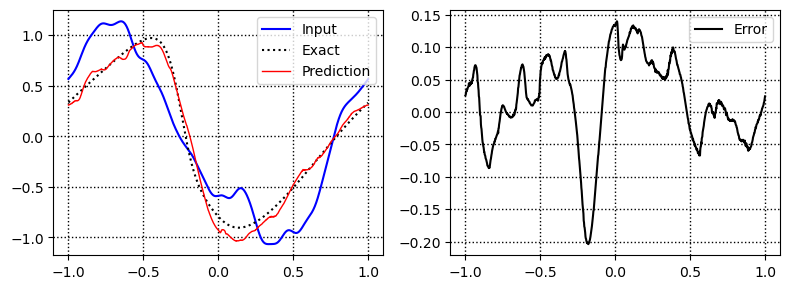

In [8]:
## Evaluation
model.eval()
with torch.no_grad():
    x, c = preprocess(x_test, c_test)
    y_pred = model(x, c)

y_pred_np = y_pred.cpu().detach().numpy()

idx = 10
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
ax1.plot(c_test_np[idx], x_test_np[idx], 'b', label="Input")
ax1.plot(c_test_np[idx], y_test_np[idx], 'k:', label="Exact")
ax1.plot(c_test_np[idx], y_pred_np[idx], 'r', lw=1, label="Prediction")
ax2.plot(c_test_np[idx], y_test_np[idx] - y_pred_np[idx], 'k', label="Error")

for ax in (ax1, ax2):
    ax.legend(loc="upper right")
    ax.grid(color='k', ls=':', lw=1)
fig.tight_layout()
plt.show()